# Classification - *correction*



In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white") # change le style par défaut des graphiques seaborn

%matplotlib inline

In [2]:
had = pandas.read_csv("https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat", header=None)
donnees = pandas.DataFrame(
    [list(map(lambda v: float(v), filter(lambda v: v!= "", h.split(" ")))) for h in had[0][::2]],
    columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Annual"]
)
donnees = donnees.query('Year < 2021')

> On choisit ici de **standardiser les données** (avec la fonction `scale()`).

In [3]:
from sklearn.preprocessing import scale

donnees_scale = scale(donnees.drop(columns = ["Year", "Annual"]))

## Rechercher une partition intéressante des années


### Avec la CAH

In [4]:
from sklearn.cluster import AgglomerativeClustering

hac = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(donnees_scale)

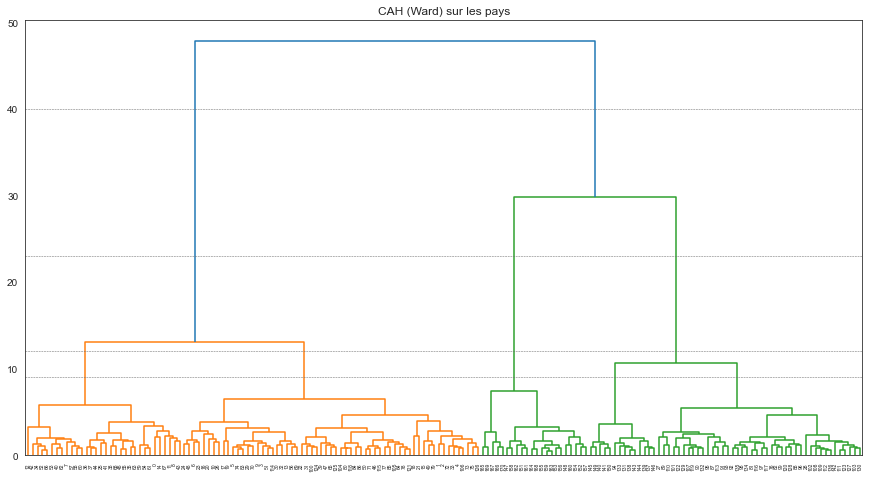

In [5]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize = (15, 8))
plt.title("CAH (Ward) sur les pays")
# plot the top three levels of the dendrogram
plot_dendrogram(hac)
plt.axhline(y = 40, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 23, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 12, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y =  9, linewidth = .5, color = "dimgray", linestyle = "--")
plt.show()

*A noter* :
    
- Un découpage en 2 ou 3 classes semble le plus logique
- On pourrait éventuellement considérer le découpage en 4 ou 5 classes intéressants, à confirmer (ou non) avec $k$-means

### Avec $k$-means

In [6]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(donnees_scale)
    inertia = inertia + [kmeans.inertia_]
inertia = pandas.DataFrame({"k": range(1, 11), "inertia": inertia})

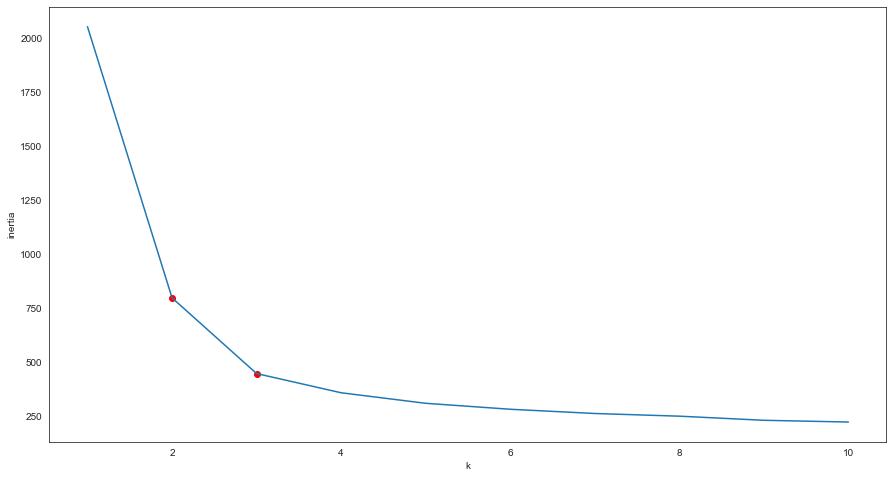

In [7]:
plt.figure(figsize = (15, 8))
seaborn.lineplot(data = inertia, x = "k", y = "inertia")
plt.scatter(2, inertia.query('k == 2')["inertia"], c = "red")
plt.scatter(3, inertia.query('k == 3')["inertia"], c = "red")
plt.show()

*A noter*

- Découpage intéressant uniquement en 2 ou 3 classes

## Représenter sur l'ACP et décrire les classes

In [8]:
from sklearn.decomposition import PCA

pca_original = PCA().fit(donnees_scale)
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(donnees_scale.shape[1])], 
        "Variance expliquée" : pca_original.explained_variance_,
        "% variance expliquée" : numpy.round(pca_original.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca_original.explained_variance_ratio_) * 100)
    }
)

*A noter* :

- La première dimension explique presque toute l'information présente dans les données

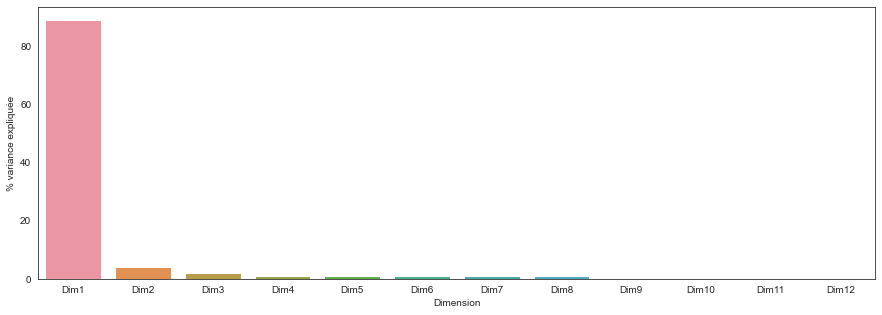

In [9]:
plt.figure(figsize = (15, 5)) # modifie la taille du graphique
seaborn.barplot(data = eig, x = "Dimension", y = "% variance expliquée")
plt.show() # cette ligne supprime l'affichage inutile en amont du graphique

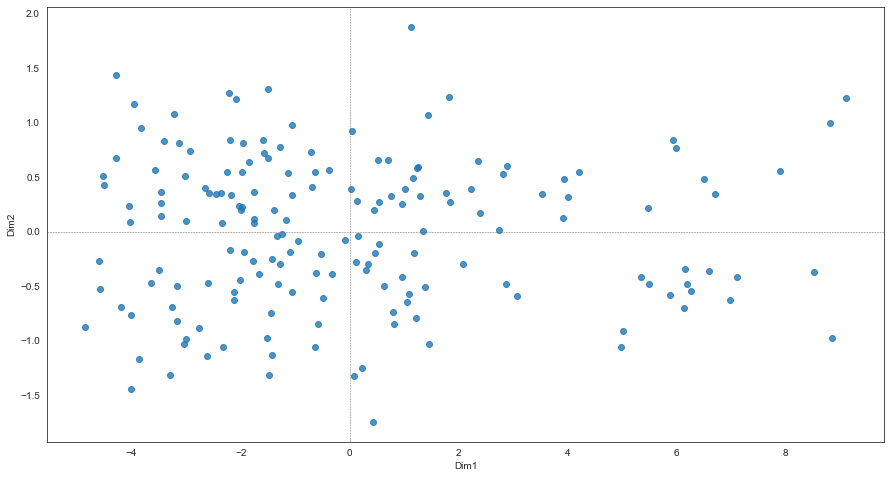

In [10]:
donnees_pca = pca_original.transform(donnees_scale)

donnees_pca_df = pandas.DataFrame({
    "Dim1" : donnees_pca[:,0], 
    "Dim2" : donnees_pca[:,1],
    "Year" : donnees["Year"]
})

fig, ax = plt.subplots(figsize=(15,8))
plt.axvline(x = 0, linewidth = .5, color = "dimgray", linestyle = "--")
plt.axhline(y = 0, linewidth = .5, color = "dimgray", linestyle = "--")
seaborn.regplot(data = donnees_pca_df, x = "Dim1", y = "Dim2", fit_reg = False)
plt.show()

Pour voir les années, on va toutes les affichées sur le graphique

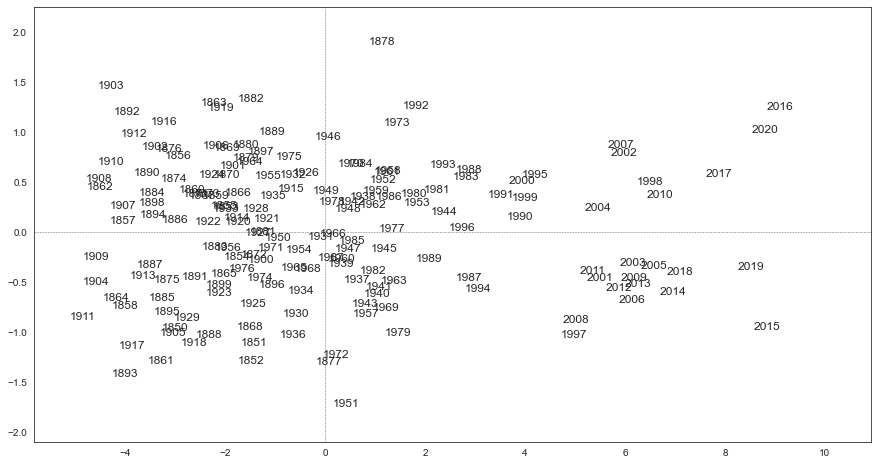

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.axvline(x = 0, linewidth = .5, color = "dimgray", linestyle = "--")
ax.axhline(y = 0, linewidth = .5, color = "dimgray", linestyle = "--")
exp = 1.2 # permet d'étendre les limites des axes pour bien intégrer toutes les années
ax.set_xlim(numpy.min(donnees_pca_df.Dim1) * exp, numpy.max(donnees_pca_df.Dim1) * exp)
ax.set_ylim(numpy.min(donnees_pca_df.Dim2) * exp, numpy.max(donnees_pca_df.Dim2) * exp)

for k in donnees_pca_df.iterrows():
    ax.annotate(round(k[1]["Year"]), (k[1]['Dim1'], k[1]['Dim2']), fontsize = 12, ha = "center")

*A noter* :

- Les valeurs élevées sont donc situées sur la droite du graphique ;
- Les années très chaudes sont toutes post-2000, avec 1998 (et 1997 dans une moindre mesure) en plus ;
- 1951 et 1878 semble se démarquer
    - 1951 : Janvier et Février froids -- Décembre (relativement) chaud
    - 1878 : Janvier (relativement) et Février chauds -- Décembre et Novembre (relativement) froids

### En 2 classes

In [12]:
kmeans2 = KMeans(n_clusters = 2).fit(donnees_scale)
donnees.assign(classe = kmeans2.labels_).drop(columns = "Year").groupby("classe").mean().round(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
classe,,,,,,,,,,,,,
0,-0.22,-0.23,-0.28,-0.23,-0.23,-0.19,-0.17,-0.17,-0.19,-0.20,-0.24,-0.25,-0.21
1,0.44,0.45,0.46,0.43,0.39,0.41,0.42,0.43,0.41,0.42,0.40,0.39,0.42


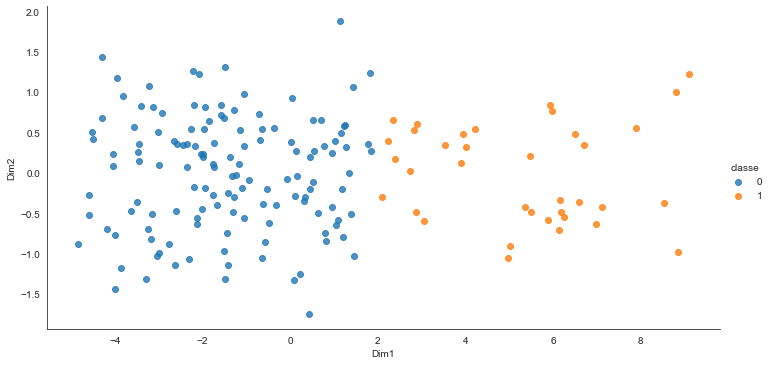

In [13]:
seaborn.lmplot(data = donnees_pca_df.assign(classe = kmeans2.labels_), 
               x = "Dim1", y = "Dim2", hue = "classe", 
               fit_reg = False, height = 5, aspect = 2)
plt.show()

*A noter* :

- Une classe d'années chaudes et une classe d'années froides
- Les années chaudes sont (presque) toutes post-crise pétrolière

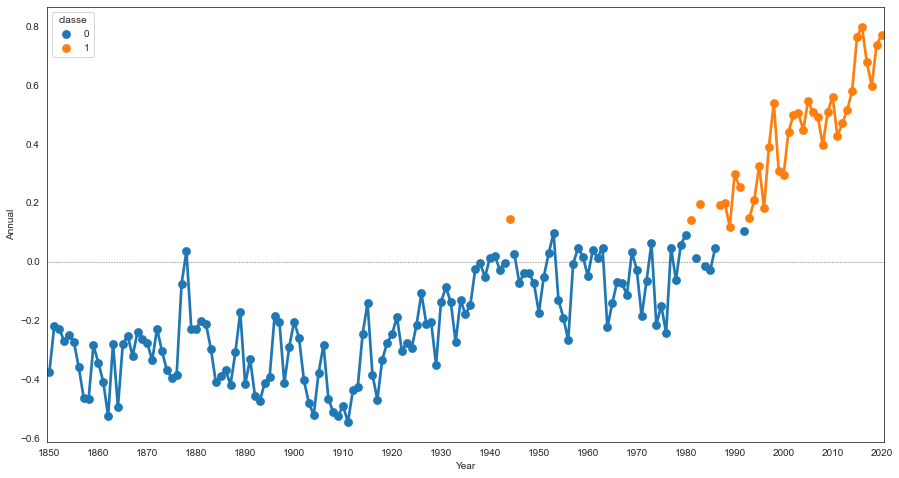

In [14]:
plt.figure(figsize = (15, 8))
plt.axhline(y = 0, linewidth = .5, color = "dimgray", linestyle = "--")
g = seaborn.pointplot(data = donnees.assign(classe = kmeans2.labels_), x = "Year", y = "Annual", hue = "classe")
g.set_xticks(range(0, 171, 10)) # <--- set the ticks first
g.set_xticklabels(range(1850, 2021, 10))
plt.show()

### En 3 classes

In [15]:
kmeans3 = KMeans(n_clusters = 3).fit(donnees_scale)
donnees.assign(classe = kmeans3.labels_).drop(columns = "Year").groupby("classe").mean().round(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
classe,,,,,,,,,,,,,
0,-0.33,-0.35,-0.40,-0.34,-0.33,-0.29,-0.25,-0.26,-0.29,-0.32,-0.36,-0.37,-0.32
1,0.50,0.54,0.55,0.54,0.47,0.49,0.50,0.52,0.49,0.51,0.50,0.46,0.50
2,0.01,0.01,-0.04,-0.00,-0.02,0.01,0.01,0.03,0.02,0.02,-0.01,-0.01,0.00


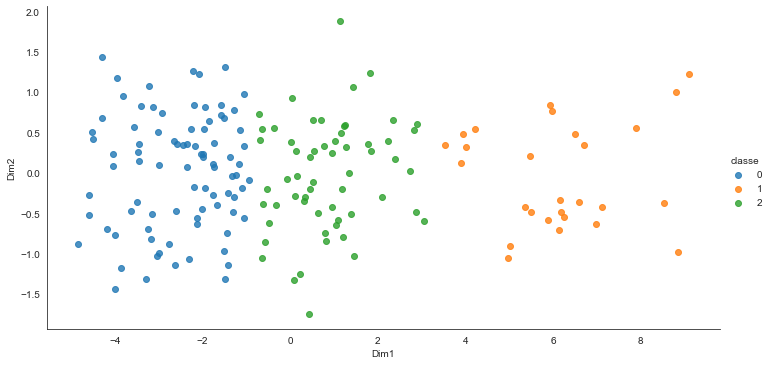

In [16]:
seaborn.lmplot(data = donnees_pca_df.assign(classe = kmeans3.labels_), 
               x = "Dim1", y = "Dim2", hue = "classe", 
               fit_reg = False, height = 5, aspect = 2)
plt.show()

*A noter* :

- une classe d'années chaudes, une d'années froides et une intermédiaire
- Le découpage respecte presque intégralement la chronologie des années

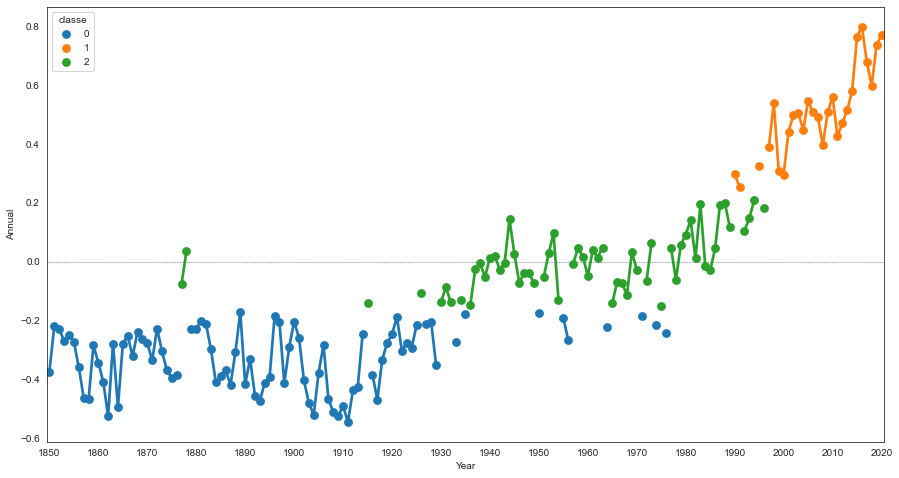

In [17]:
plt.figure(figsize = (15, 8))
plt.axhline(y = 0, linewidth = .5, color = "dimgray", linestyle = "--")
g = seaborn.pointplot(data = donnees.assign(classe = kmeans3.labels_), x = "Year", y = "Annual", hue = "classe")
g.set_xticks(range(0, 171, 10)) # <--- set the ticks first
g.set_xticklabels(range(1850, 2021, 10))
plt.show()